In [1]:
import numpy as np
import pandas as pd

In [2]:
from vresutils import reatlas as vreatlas, grid as vgrid, shapes as vshapes, landuse as vlanduse
from generation import resource
from load.europe import timeseries_europe

In [3]:
%matplotlib inline
import matplotlib.pyplot as plt
import vresutils.plot as vplot

In [4]:
cutout = vreatlas.Cutout(username='becker', cutoutname='Europe_2011_2014')

In [5]:
ocean_depth_cutoff = 50 # in m or None

windturbines = dict(onshore='Vestas_V112_3MW', offshore='NREL_ReferenceTurbine_5MW_offshore')
solarpanel = dict(panel='KANENA', orientation='latitude_optimal')

# Potentials

\*potentials are meant to hold a value of $x \, MW/km^2$ for each grid cell determined from landuse data, it is later multiplied by the cell areas to determine the maximum grid cell production. For vlanduse.corine_for_cutout to work properly one needs the python package rasterio and the gdalwarp command. vlanduse.corine_for_cutout takes a list of corine grid_codes as input.

wind is preferred from PhD thesis by ed sharp p. 177

solar comes from everything but forests and waters

A homogeneous value of $1 \, MW/km^2$ is assumed for wind onshore/offshore and solar. FIX.

In [7]:
%%time
onshorepotentials = vlanduse.corine_for_cutout(cutout, [12, 13, 14, 18, 23, 24, 25, 26, 27, 28, 29, 35, 36]) * 1.
offshorepotentials = 1.
solarpotentials = vlanduse.corine_for_cutout(cutout, [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18,
                                                      19, 20, 21, 22, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36]) * 1.

CPU times: user 16.7 s, sys: 428 ms, total: 17.1 s
Wall time: 1min 2s


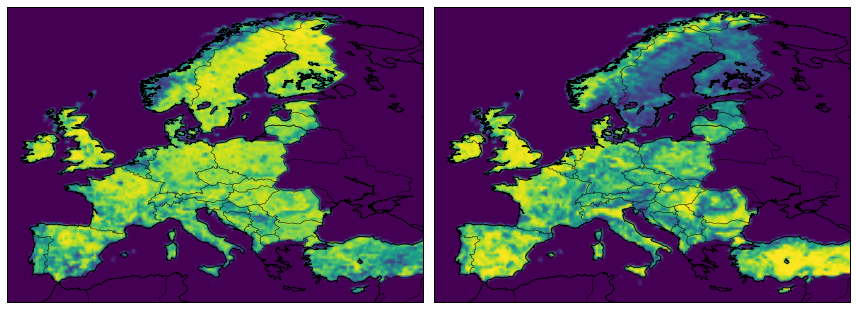

In [9]:
fig, axes = plt.subplots(1, 2, figsize=(12,6))
ax_iter = axes.flat
for ax, data in zip(axes.flat, [onshorepotentials, solarpotentials]):
    im = ax.imshow(data, extent=cutout.extent, cmap='viridis')
    vplot.draw_basemap(ax=ax)
fig.tight_layout()

In [36]:
print(solarpotentials.shape)
print(pd.DataFrame(solarpotentials).max().max())

(123, 173)
1.0


# Time-Series

## Generation

In [12]:
partition = vreatlas.partition_from_emil(cutout)

Serving call to nuts1 from file vresutils.shapes.nuts1__.pickle of cache: 8.0 msec


In [41]:
partition["AL"].shape

(123, 173)

### Masks

Masks are used to adjust the plain capacity factor layout (i.e. one turbine/m^2-panel at the location of a grid cell) by their geographical potential in terms of MW. They are constructed by combining landuse-specific $MW/km^2$ coefficients (\*potentials) with the actual grid cell area in $km^2$.

In [13]:
reatlas_cell_areas = np.asarray(map(vshapes.area, cutout.grid_cells())).reshape(cutout.shape)*1e-6

In [14]:
onshoremap = cutout.meta['onshoremap']
onshoremask = reatlas_cell_areas * onshorepotentials * onshoremap
solarmask = reatlas_cell_areas * solarpotentials * onshoremap
offshoremask = reatlas_cell_areas * offshorepotentials * (1. - onshoremap)

In [15]:
if ocean_depth_cutoff is not None:
    offshoremask *= (cutout.meta['heights'] > -ocean_depth_cutoff)

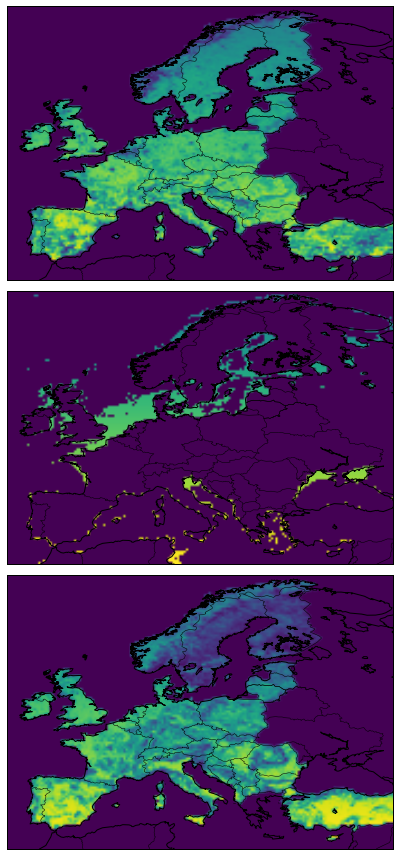

In [16]:
fig, axes = plt.subplots(3, 1, figsize=(8,12))
ax_iter = axes.flat
for ax, data in zip(axes.flat, [onshoremask, offshoremask, solarmask]):
    ax.imshow(data, extent=cutout.extent, cmap='viridis')
    vplot.draw_basemap(ax=ax)
fig.tight_layout()

### REAtlas

In [17]:
%%time
windlayout = resource.capacity_factor_layout(windturbines, cutout)
onshore = resource.unit_capacity_timeseries(dict(onshore=windturbines['onshore']), partition,
                                            onshoremask * windlayout, cutout)
offshore = resource.unit_capacity_timeseries(dict(offshore=windturbines['offshore']), partition,
                                             offshoremask * windlayout, cutout)

CPU times: user 3.2 s, sys: 752 ms, total: 3.96 s
Wall time: 2min 25s


In [18]:
%%time
solarlayout = resource.capacity_factor_layout(solarpanel, cutout)
solar = resource.unit_capacity_timeseries(solarpanel, partition, solarlayout * solarmask, cutout)

CPU times: user 1.74 s, sys: 284 ms, total: 2.03 s
Wall time: 2min 10s


In [44]:
onshore.describe()

AL            AT            BA            BE            BG  \
count  35064.000000  35064.000000  35064.000000  35064.000000  35064.000000   
mean       0.120876      0.143756      0.107886      0.291873      0.138423   
std        0.123654      0.155676      0.144324      0.302387      0.156605   
min        0.000000      0.000011      0.000000      0.000000      0.000019   
25%        0.028253      0.032126      0.019903      0.053375      0.028834   
50%        0.082314      0.081622      0.053033      0.168358      0.076427   
75%        0.178042      0.204003      0.128134      0.457053      0.190770   
max        0.961235      0.858131      0.969310      1.000000      0.939546   

                 CH            CZ            DE            DK            EE  \
count  35064.000000  3.506400e+04  35064.000000  35064.000000  35064.000000   
mean       0.108338  1.918903e-01      0.266638      0.453453      0.327209   
std        0.113339  2.239775e-01      0.240774      0.312729      0.292805   
min        0.000000  7.069198e-07      0.000586      0.000183      0.000088   
25%        0.028785  3.108693e-02      0.078406      0.168620      0.081760   
50%        0.070778  9.954437e-02      0.180799      0.403969      0.226684   
75%        0.148357  2.723860e-01      0.396582      0.734848      0.526822   
max        0.854073  1.000000e+00      0.994359      1.000000      1.000000   

           ...                 MK            NL            NO            PL  \
count      ...       35064.000000  35064.000000  35064.000000  35064.000000   
mean       ...           0.054762      0.369149      0.243024      0.238151   
std        ...           0.084741      0.312851      0.164510      0.224299   
min        ...           0.000000      0.000005      0.001546      0.000933   
25%        ...           0.006961      0.099282      0.115303      0.072490   
50%        ...           0.024489      0.272904      0.207492      0.156740   
75%        ...           0.064899      0.599611      0.333914      0.333793   
max        ...           0.798078      1.000000      0.948086      0.999238   

                 PT            RO            RS            SE            SI  \
count  35064.000000  35064.000000  35064.000000  35064.000000  35064.000000   
mean       0.173529      0.134932      0.112893      0.274438      0.081013   
std        0.186791      0.132085      0.150453      0.200476      0.123301   
min        0.000003      0.000080      0.000000      0.003668      0.000000   
25%        0.040236      0.040841      0.019187      0.110778      0.010719   
50%        0.104072      0.085748      0.053693      0.225887      0.035445   
75%        0.241376      0.188173      0.139654      0.397882      0.091525   
max        0.999966      0.950093      0.981058      0.991179      0.986869   

                 SK  
count  35064.000000  
mean       0.133737  
std        0.166053  
min        0.000000  
25%        0.022154  
50%        0.067919  
75%        0.181007  
max        0.999241  

[8 rows x 33 columns]

### Determine peak production

In [19]:
def renorm(x): return x / x.max()
onshoremap = cutout.meta['onshoremap']
onshore_p_max_pu = partition.map(lambda x: (renorm(x * windlayout * onshoremap) * onshoremask).sum())
offshore_p_max_pu = partition.map(lambda x: (renorm(x * windlayout * (1.-onshoremap)) * offshoremask).sum())
solar_p_max_pu = partition.map(lambda x: (renorm(x * solarlayout * onshoremap) * solarmask).sum())

In [20]:
onshore_p_max_pu / 1e3

AL      5.650611
AT     27.448101
BA     19.880450
BE      9.969266
BG     35.957814
CH     15.857436
CZ     42.309281
DE    118.047157
DK     19.256428
EE     19.320429
ES    108.301282
FI    127.766767
FR    147.762490
GB    107.871742
GR      0.637336
HR     15.186201
HU     45.708833
IE     33.135795
IT     57.577567
LT     21.076168
LU      1.800650
LV     27.802932
ME      7.764107
MK     13.020823
NL     12.372654
NO     58.876397
PL    108.328583
PT     19.951918
RO     53.346804
RS     32.514269
SE    169.894992
SI      6.989463
SK     19.373122
dtype: float64

#### w/o renorm

In [21]:
pd.concat({'w/ renorm': onshore_p_max_pu,
           'w/o renorm': partition.map(lambda x: (x * onshoremask).sum())}, axis=1) /1e3

w/ renorm  w/o renorm
AL    5.650611   18.129510
AT   27.448101   66.771834
BA   19.880450   36.024667
BE    9.969266   16.823514
BG   35.957814   89.127493
CH   15.857436   27.259456
CZ   42.309281   64.686561
DE  118.047157  288.337148
DK   19.256428   30.448696
EE   19.320429   34.777273
ES  108.301282  343.188391
FI  127.766767  277.347592
FR  147.762490  410.303463
GB  107.871742  192.805017
GR    0.637336    2.473326
HR   15.186201   34.710029
HU   45.708833   76.662208
IE   33.135795   55.768713
IT   57.577567  194.098769
LT   21.076168   46.225765
LU    1.800650    2.180828
LV   27.802932   51.053286
ME    7.764107    9.575499
MK   13.020823   20.184521
NL   12.372654   20.717952
NO   58.876397  181.656827
PL  108.328583  262.504014
PT   19.951918   52.033849
RO   53.346804  189.056381
RS   32.514269   50.905230
SE  169.894992  371.520607
SI    6.989463   13.288294
SK   19.373122   40.885187

In [22]:
offshore_p_max_pu

AL      2589.783497
AT              NaN
BA              NaN
BE      2803.722478
BG      2067.585995
CH              NaN
CZ              NaN
DE     46363.427045
DK     61922.974671
EE     12984.312879
ES      8693.688973
FI     38325.768594
FR     40297.454617
GB    111245.521419
GR     24302.680852
HR     11962.337619
HU              NaN
IE     12071.550031
IT     19713.694713
LT      2949.207325
LU              NaN
LV     10827.352593
ME      1631.585824
MK              NaN
NL     59110.381796
NO     31256.556758
PL      9528.031776
PT      2801.112139
RO      8189.332431
RS              NaN
SE     61345.646548
SI              NaN
SK              NaN
dtype: float64

In [23]:
solar_p_max_pu

AL     17262.720081
AT     42058.684187
BA     25106.273924
BE     21953.677494
BG     60150.228848
CH     22522.814344
CZ     44600.098622
DE    197665.510457
DK     30237.630771
EE     17899.877525
ES    345390.849641
FI     80369.312458
FR    284860.395640
GB    153210.002574
GR      1815.645530
HR     28810.093385
HU     68755.655516
IE     46847.488133
IT    172226.094764
LT     38216.044388
LU      1877.965937
LV     30845.316641
ME      6765.607680
MK     15618.617625
NL     26148.920924
NO    138845.765837
PL    175704.771848
PT     57545.717966
RO    138492.923385
RS     47733.516181
SE    126194.108753
SI      7695.957609
SK     24880.889777
dtype: float64

## Load

In [24]:
load = timeseries_europe()

Caching call to read_entsoe_consumption in load.europe.read_entsoe_consumption_d446ec8416cfa4a02b903ea99e74c27f3a25524a_.pickle: WARNING *** OLE2 inconsistency: SSCS size is 0 but SSAT size is non-zero
WARNING *** OLE2 inconsistency: SSCS size is 0 but SSAT size is non-zero
WARNING *** OLE2 inconsistency: SSCS size is 0 but SSAT size is non-zero
WARNING *** OLE2 inconsistency: SSCS size is 0 but SSAT size is non-zero
WARNING *** OLE2 inconsistency: SSCS size is 0 but SSAT size is non-zero
WARNING *** OLE2 inconsistency: SSCS size is 0 but SSAT size is non-zero
WARNING *** OLE2 inconsistency: SSCS size is 0 but SSAT size is non-zero
WARNING *** OLE2 inconsistency: SSCS size is 0 but SSAT size is non-zero
WARNING *** OLE2 inconsistency: SSCS size is 0 but SSAT size is non-zero
WARNING *** OLE2 inconsistency: SSCS size is 0 but SSAT size is non-zero
WARNING *** OLE2 inconsistency: SSCS size is 0 but SSAT size is non-zero
WARNING *** OLE2 inconsistency: SSCS size is 0 but SSAT size is non-

In [25]:
load

Country                       AT     BA      BE     BG     CH     CS     CY  \
2005-12-31 23:00:00+00:00  6.297  1.425   9.829  4.293  0.000  5.781    NaN   
2006-01-01 00:00:00+00:00  6.005  1.358   9.447  4.186  0.000  5.747    NaN   
2006-01-01 01:00:00+00:00  5.743  1.283   9.062  4.026  0.000  5.380    NaN   
2006-01-01 02:00:00+00:00  5.397  1.175   8.589  3.877  0.000  4.978    NaN   
2006-01-01 03:00:00+00:00  5.213  1.134   8.247  3.724  0.000  4.735    NaN   
2006-01-01 04:00:00+00:00  5.190  1.155   8.045  3.589  0.000  4.554    NaN   
2006-01-01 05:00:00+00:00  4.916  1.175   7.941  3.475  0.000  4.423    NaN   
2006-01-01 06:00:00+00:00  5.158  1.194   7.554  3.420  0.000  4.416    NaN   
2006-01-01 07:00:00+00:00  5.405  1.292   7.525  3.468  0.000  4.617    NaN   
2006-01-01 08:00:00+00:00  5.731  1.377   7.649  3.641  0.000  4.976    NaN   
2006-01-01 09:00:00+00:00  6.075  1.456   7.983  3.791  0.000  5.224    NaN   
2006-01-01 10:00:00+00:00  6.385  1.498   8.334  3.840  0.000  5.366    NaN   
2006-01-01 11:00:00+00:00  6.276  1.473   8.621  3.868  0.000  5.413    NaN   
2006-01-01 12:00:00+00:00  6.249  1.437   8.597  3.816  0.000  5.319    NaN   
2006-01-01 13:00:00+00:00  6.247  1.426   8.410  3.708  0.000  5.250    NaN   
2006-01-01 14:00:00+00:00  6.231  1.458   8.337  3.759  0.000  5.379    NaN   
2006-01-01 15:00:00+00:00  6.603  1.598   8.405  3.935  0.000  5.701    NaN   
2006-01-01 16:00:00+00:00  6.979  1.677   8.992  4.459  0.000  5.905    NaN   
2006-01-01 17:00:00+00:00  7.022  1.660   9.227  4.659  0.000  5.930    NaN   
2006-01-01 18:00:00+00:00  6.930  1.646   9.225  4.577  0.000  5.927    NaN   
2006-01-01 19:00:00+00:00  6.560  1.604   9.084  4.411  0.000  5.862    NaN   
2006-01-01 20:00:00+00:00  6.170  1.511   9.036  4.301  0.000  5.764    NaN   
2006-01-01 21:00:00+00:00  6.501  1.432   9.704  4.346  0.000  5.583    NaN   
2006-01-01 22:00:00+00:00  6.168  1.328   9.840  4.335  0.000  5.372    NaN   
2006-01-01 23:00:00+00:00  5.900  1.220   9.250  4.030  0.000  5.232    NaN   
2006-01-02 00:00:00+00:00  5.643  1.138   8.802  3.823  0.000  4.935    NaN   
2006-01-02 01:00:00+00:00  5.524  1.105   8.401  3.678  0.000  4.624    NaN   
2006-01-02 02:00:00+00:00  5.372  1.079   8.167  3.571  0.000  4.393    NaN   
2006-01-02 03:00:00+00:00  5.481  1.072   8.097  3.419  0.000  4.254    NaN   
2006-01-02 04:00:00+00:00  5.941  1.106   8.259  3.486  0.000  4.262    NaN   
...                          ...    ...     ...    ...    ...    ...    ...   
2014-12-30 17:00:00+00:00  9.805  2.081  11.204  6.387  6.747    NaN  0.587   
2014-12-30 18:00:00+00:00  9.234  2.059  10.814  6.345  6.568    NaN  0.579   
2014-12-30 19:00:00+00:00  8.621  1.988  10.251  6.125  6.376    NaN  0.559   
2014-12-30 20:00:00+00:00  8.124  1.930   9.816  5.914  6.349    NaN  0.533   
2014-12-30 21:00:00+00:00  8.135  1.838  10.132  5.830  6.384    NaN  0.491   
2014-12-30 22:00:00+00:00  7.537  1.661  10.154  5.538  6.169    NaN  0.447   
2014-12-30 23:00:00+00:00  7.143  1.478   9.487  5.072  6.202    NaN  0.390   
2014-12-31 00:00:00+00:00  6.820  1.356   8.937  4.708  6.090    NaN  0.348   
2014-12-31 01:00:00+00:00  6.606  1.292   8.472  4.544  5.988    NaN  0.323   
2014-12-31 02:00:00+00:00  6.478  1.254   8.247  4.434  6.127    NaN  0.310   
2014-12-31 03:00:00+00:00  6.615  1.260   8.147  4.472  5.943    NaN  0.308   
2014-12-31 04:00:00+00:00  7.057  1.339   8.288  4.464  5.814    NaN  0.322   
2014-12-31 05:00:00+00:00  7.525  1.554   8.762  4.556  5.774    NaN  0.342   
2014-12-31 06:00:00+00:00  8.200  1.753   9.088  4.813  5.926    NaN  0.393   
2014-12-31 07:00:00+00:00  8.690  1.871   9.707  5.332  6.185    NaN  0.445   
2014-12-31 08:00:00+00:00  8.931  1.969  10.030  5.816  6.333    NaN  0.466   
2014-12-31 09:00:00+00:00  9.022  1.984  10.198  6.038  6.338    NaN  0.474   
2014-12-31 10:00:00+00:00  8.958  1.946  10.274  6.112  6.123    NaN  0.475   
2014-12-31 11:00:00+00:00  8.759  1.919  10.148  6

## Choose common data boundaries

In [26]:
graph = vgrid.eu()

In [27]:
timeseries = pd.Panel(dict(load=load, windon=onshore, windoff=offshore, solar=solar))
timeseries = timeseries.ix[:,:,graph.nodes()]
timeseries.dropna(axis=1, inplace=True)

In [28]:
timeseries

<class 'pandas.core.panel.Panel'>
Dimensions: 4 (items) x 35062 (major_axis) x 30 (minor_axis)
Items axis: load to windon
Major_axis axis: 2011-01-01 00:00:00+00:00 to 2014-12-31 22:00:00+00:00
Minor_axis axis: AT to LT